In [93]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import random
from patsy import dmatrices
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [3]:
ip_df = pd.read_csv('IpAddress_to_Country.csv')

In [4]:
fraud_df = pd.read_csv('Fraud_Data.csv')

In [5]:
ip_df['upper_lower'] = list(zip(ip_df.loc[:,'lower_bound_ip_address'], ip_df.loc[:, 'upper_bound_ip_address']))

In [6]:
dict_df = ip_df.loc[:, ['country', 'upper_lower']]

Map IP addresses to the corresponding country in a dictionary

In [7]:
d = dict_df.groupby('upper_lower')['country'].apply(list).to_dict()


#### Create a function to extract countries from ip addresses using ip address dictionary

In [8]:
upper_bounds=[(v[0], k[1]) for k,v in d.items()]
def get_country(x):
    for c,ip in upper_bounds:
        if x<=ip: return c  # didn't end up using

### Feature Engineering

#### Find the countries for all the IP addresses listed

In [9]:
v = ip_df.loc[:, 'lower_bound_ip_address':'upper_bound_ip_address'].apply(tuple, 1).tolist()
idx = pd.IntervalIndex.from_tuples(v, closed='both')
fraud_df.loc[:, 'country'] = ip_df.loc[idx.get_indexer(fraud_df['ip_address'].values), 'country'].values

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


#### Make dummies for the source and browser

In [37]:
fraud_df = fraud_df.merge(pd.get_dummies(fraud_df.source), left_index=True, right_index=True)

In [38]:
fraud_df = fraud_df.merge(pd.get_dummies(fraud_df.browser), left_index=True, right_index=True)

In [39]:
fraud_df['sex'] = pd.Series(np.where(fraud_df.sex.values == 'F', 1, 0),
          fraud_df.index)

In [40]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])

In [41]:
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

#### Find difference in signup time and purchase time

In [42]:
fraud_df['time_to_purchase'] = fraud_df['purchase_time'] -fraud_df['signup_time']

In [43]:
fraud_df.time_to_purchase = fraud_df.time_to_purchase.apply(lambda x: x / timedelta (days=1))

split dataframe and find percent countries in test set above a certain threshold

In [44]:
date_to_split = dt.datetime(2015, 7, 31) #split on this date for the train/test split

In [45]:
calculate_percent_fraud = fraud_df[fraud_df.signup_time <= date_to_split]

In [46]:
percent_fraud_df = pd.DataFrame(calculate_percent_fraud.groupby(['country'])['class'].sum()/fraud_df.groupby(['country'])['class'].count())

#### Find countries with fraud percent above 20

In [47]:
fraud_countries = list(percent_fraud_df.loc[percent_fraud_df['class'] > 0.2].index)

In [48]:
def possible_fraud(country):
    if country in fraud_countries:
        return 1
    else:
        return 0

In [49]:
fraud_df['possible_fraud'] = fraud_df['country'].apply(lambda x: possible_fraud(x))

In [50]:
fraud_df.isna().sum()  #see if there are any missing values

user_id                 0
signup_time             0
purchase_time           0
purchase_value          0
device_id               0
source                  0
browser                 0
sex                     0
age                     0
ip_address              0
class                   0
country             21966
time_to_purchase        0
possible_fraud          0
Ads                     0
Direct                  0
SEO                     0
Chrome                  0
FireFox                 0
IE                      0
Opera                   0
Safari                  0
dtype: int64

#### Create X and y matrices for model

In [51]:
X = fraud_df.loc[:, ['purchase_value', 'sex', 'age', 'Ads', 'Direct', 'SEO', 'time_to_purchase', 'Chrome',
       'FireFox', 'IE', 'Opera', 'Safari', 'possible_fraud']]

In [52]:
y = fraud_df.loc[:, ['class']]

In [31]:
df_train = fraud_df[fraud_df.signup_time <= date_to_split]

In [32]:
df_test = fraud_df[fraud_df.signup_time >= date_to_split]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [70]:
X_train2 = X_train.loc[:, ['purchase_value', 'sex', 'age', 'Ads', 'Direct', 'SEO', 'time_to_purchase', 'Chrome',
       'FireFox', 'IE', 'Opera', 'Safari']] #dropped potential fraud due to data leakage concerns

In [71]:
y_train2 = y_train.loc[:, ['class']]

In [72]:
X_test2 = X_test.loc[:, ['purchase_value', 'sex', 'age', 'Ads', 'Direct', 'SEO', 'time_to_purchase', 'Chrome',
       'FireFox', 'IE', 'Opera', 'Safari']] #dropped potential fraud due to data leakage concerns

In [73]:
y_test2 = y_test.loc[:, ['class']]

In [54]:
rf_classifier = RandomForestClassifier(max_depth=10, n_estimators=1000)

In [57]:
X_train.head()

,purchase_value,sex,age,Ads,Direct,SEO,time_to_purchase,Chrome,FireFox,IE,Opera,Safari,possible_fraud
74068,26,0,41,1,0,0,0.000012,1,0,0,0,0,0
129509,19,1,34,0,0,1,103.275370,1,0,0,0,0,0
95250,12,0,40,1,0,0,11.437755,0,0,1,0,0,0
138881,16,1,34,0,0,1,60.341470,0,0,0,0,1,0
43829,42,1,22,0,0,1,94.494167,1,0,0,0,0,0


In [56]:
rf_classifier.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [58]:
preds = rf_classifier.predict_proba(X_test)

In [59]:
pos_preds = preds[:,1]

In [60]:
y_test.sum()

class    3544
dtype: int64

In [61]:
y_test.sum()/len(y_test)

class    0.093811
dtype: float64

In [62]:
rf_classifier.score(X_test, y_test)  #accuracy

0.9571178993064746

In [63]:
log_loss(y_test, pos_preds)

0.1771880982224652

In [74]:
rf_classifier.fit(X_train2, y_train2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
preds2 = rf_classifier.predict_proba(X_test2)

In [76]:
rf_classifier.score(X_test2, y_test2)

0.9571178993064746

In [78]:
log_loss(y_test2, preds2)

0.1763394980657516

In [92]:
(list(X.columns))

['purchase_value',
 'sex',
 'age',
 'Ads',
 'Direct',
 'SEO',
 'time_to_purchase',
 'Chrome',
 'FireFox',
 'IE',
 'Opera',
 'Safari',
 'possible_fraud']

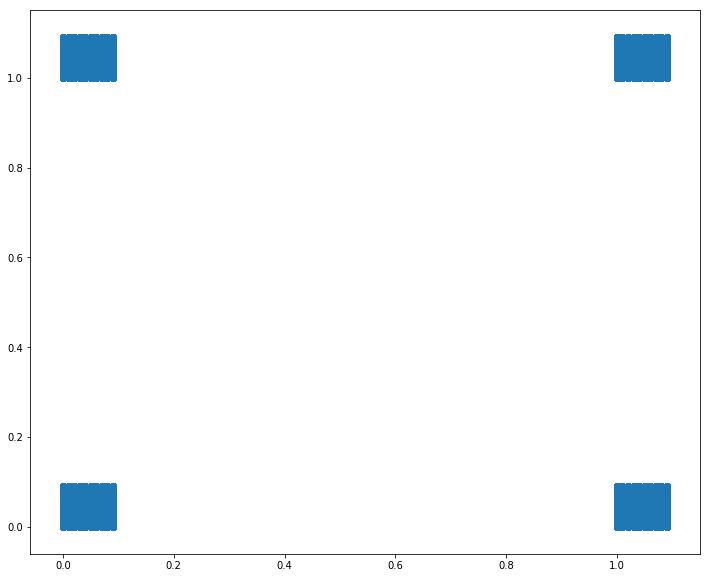

In [146]:
fig, axs = plt.subplots(1, figsize = (12,10))
samples = list(np.arange(0, 0.1, 0.01))
chrome = [x + random.sample(samples, 1)[0] for x in X.Chrome.values]
ys = [label + random.sample(samples, 1)[0] for label in y.values]
axs.scatter(chrome, ys)

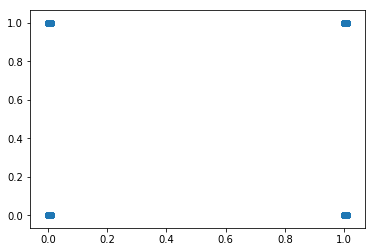

In [141]:
plt.scatter(chrome, y.values)

In [135]:
chrome = [x + random.sample(samples, 1)[0] for x in X.Chrome.values]

In [136]:
chrome

[1.8,
 1.26,
 0.8200000000000001,
 0.9400000000000001,
 0.29,
 1.0,
 1.5,
 0.26,
 0.39,
 0.0,
 0.84,
 1.83,
 0.64,
 0.2,
 0.97,
 0.48,
 0.79,
 0.98,
 0.52,
 0.43,
 0.03,
 1.81,
 1.38,
 0.41000000000000003,
 0.73,
 0.93,
 0.46,
 1.73,
 0.22,
 1.24,
 0.39,
 0.86,
 1.21,
 0.53,
 0.08,
 0.45,
 0.04,
 0.51,
 1.57,
 0.99,
 1.6400000000000001,
 1.05,
 0.33,
 0.02,
 0.45,
 0.16,
 0.44,
 1.07,
 0.35000000000000003,
 1.48,
 0.08,
 0.02,
 0.0,
 0.85,
 0.8200000000000001,
 1.76,
 0.65,
 1.9500000000000002,
 1.97,
 0.9,
 0.51,
 1.42,
 0.53,
 0.2,
 0.04,
 0.56,
 0.24,
 0.1,
 1.54,
 0.92,
 0.27,
 1.96,
 0.36,
 0.92,
 0.81,
 1.38,
 0.08,
 0.3,
 0.5700000000000001,
 1.11,
 1.77,
 0.93,
 1.31,
 0.9,
 0.12,
 1.8,
 0.08,
 0.45,
 1.96,
 0.47000000000000003,
 0.11,
 0.28,
 1.7000000000000002,
 1.99,
 0.42,
 1.62,
 0.48,
 1.44,
 1.58,
 0.72,
 0.55,
 0.85,
 1.28,
 0.46,
 0.9,
 0.24,
 1.4100000000000001,
 0.92,
 0.74,
 0.34,
 0.11,
 0.98,
 1.54,
 0.32,
 0.41000000000000003,
 0.18,
 1.37,
 0.33,
 0.96,
 0.76,
 

In [112]:
list(np.arange(0, 1, 0.01))

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [123]:
random.sample(samples, 1)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'